In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [5]:
from pathlib import Path
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

image_size = 72
train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((image_size,image_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img
    
train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = train_datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [6]:
x_train = []
y_train = []
x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(valid_generator)

for i in range(len(train_generator)-1):
    x_train = np.append(x_train, train_generator[i+1][0], axis=0)
    y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(valid_generator)-1):
    x_test = np.append(x_test, valid_generator[i+1][0], axis=0)
    y_test = np.append(y_test, valid_generator[i+1][1], axis=0)

In [7]:
y_test = y_test.astype(int).reshape((35,1))
y_train = y_train.astype(int).reshape((280,1))

In [8]:
num_classes = 7
input_shape = (72, 72, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [10]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [11]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [13]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [14]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [15]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=30,#num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/30
252/252 [==============================] - 96s 340ms/step - loss: 20.5125 - accuracy: 0.2778 - val_loss: 16.8332 - val_accuracy: 0.3571
Epoch 2/30
252/252 [==============================] - 81s 323ms/step - loss: 8.5068 - accuracy: 0.4087 - val_loss: 6.6375 - val_accuracy: 0.5000
Epoch 3/30
252/252 [==============================] - 81s 322ms/step - loss: 3.8977 - accuracy: 0.5040 - val_loss: 3.0981 - val_accuracy: 0.4286
Epoch 4/30
252/252 [==============================] - 80s 318ms/step - loss: 2.1387 - accuracy: 0.6032 - val_loss: 0.8030 - val_accuracy: 0.8571
Epoch 5/30
252/252 [==============================] - 81s 321ms/step - loss: 2.3758 - accuracy: 0.5873 - val_loss: 1.4065 - val_accuracy: 0.5714
Epoch 6/30
252/252 [==============================] - 80s 317ms/step - loss: 1.0138 - accuracy: 0.7063 - val_loss: 0.7166 - val_accuracy: 0.8571
Epoch 7/30
252/252 [==============================] - 94s 373ms/step - loss: 0.8496 - accuracy: 0.7579 - val_loss: 1.0717 - val_

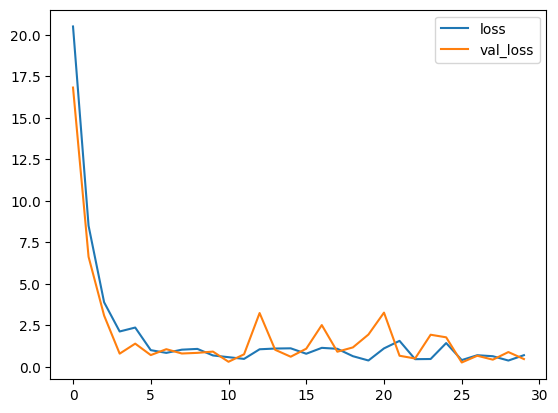

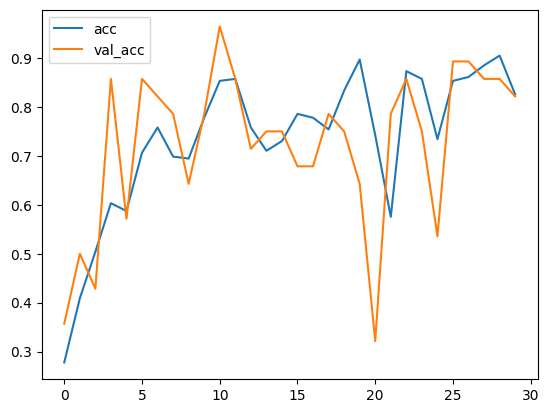

In [16]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [17]:
probs = vit_classifier.predict(x_test)

2/2 [==============================] - 2s 89ms/step


Precisão: 0.7428571428571429


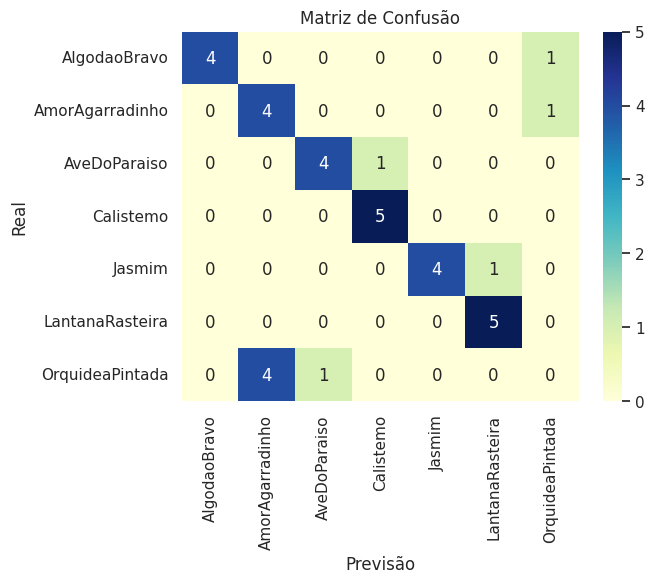

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1).reshape(35,1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_test

# Obter os nomes das classes
class_names = list(valid_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
